In [ ]:
'''
requirments.txt
tensorflow==2.14
tensorflow-addons
tf2onnx
onnxruntime
'''

# Deep Voice Classifier Using Vision Transformer

## Flow
1. Load wav Data
2. Convert to Mel Spectogram
3. Set Hyperparameter
4. Define Vision Transformer
5. Model Training & Evaluate
6. Export Model to ONNX

## Dataset
- Train
    - REAL
    - FAKE
- Valid
    - REAL
    - FAKE
- Test
    - REAL
    - FAKE

## Import Libraries

In [3]:
import os
os.chdir('./') #  specify root path
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_addons as tfa
import keras

import tf2onnx

# Set seeds for reproducibility
def set_seed(seed=530):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed()

## Load Data & Preprocessing

In [74]:
def extract_melspectrograms(audio_path, sr=16000, n_mels=128, hop_length=512):
    features = []
    labels = []
    for folder in os.listdir(audio_path):
        folder_path = os.path.join(audio_path, folder)
        if folder == '.DS_Store':
            continue
        for file in tqdm(os.listdir(folder_path)):
            file_path = os.path.join(folder_path, file)
            try:
                # Load audio file
                audio, _ = librosa.load(file_path, sr=sr)
                # Calculate number of samples per 1 second
                samples_per_second = sr
                num_segments = int(len(audio) / samples_per_second)

                for i in range(num_segments):
                    start_sample = i * samples_per_second
                    end_sample = start_sample + samples_per_second
                    segment = audio[start_sample:end_sample]

                    # Extract Mel-spectrogram
                    mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, hop_length=hop_length)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                    features.append(mel_spec_db)

                    # Assign label
                    label = 1 if folder == 'FAKE' else 0
                    labels.append(label)
            except Exception as e:
                print(f"Error encountered while parsing file: {file_path}")
                continue
    return np.array(features), np.array(labels)


train_path = './data_wav/Train'
valid_path = './data_wav/Valid'
test_path = './data_wav/Test'

X_train, y_train = extract_melspectrograms(train_path)
X_valid, y_valid = extract_melspectrograms(valid_path)
X_test, y_test = extract_melspectrograms(test_path)

# Ensure all Mel-spectrograms have the same shape
max_length = max([x.shape[1] for x in X_train])
X_train = np.array([np.pad(x, ((0, 0), (0, max_length - x.shape[1])), mode='constant') if x.shape[1] < max_length else x for x in X_train])
max_length = max([x.shape[1] for x in X_valid])
X_valid = np.array([np.pad(x, ((0, 0), (0, max_length - x.shape[1])), mode='constant') if x.shape[1] < max_length else x for x in X_valid])
max_length = max([x.shape[1] for x in X_test])
X_test = np.array([np.pad(x, ((0, 0), (0, max_length - x.shape[1])), mode='constant') if x.shape[1] < max_length else x for x in X_test])

# Reshape input data to add channel dimension
X_train= X_train[..., np.newaxis]
X_valid= X_valid[..., np.newaxis]
X_test= X_test[..., np.newaxis]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

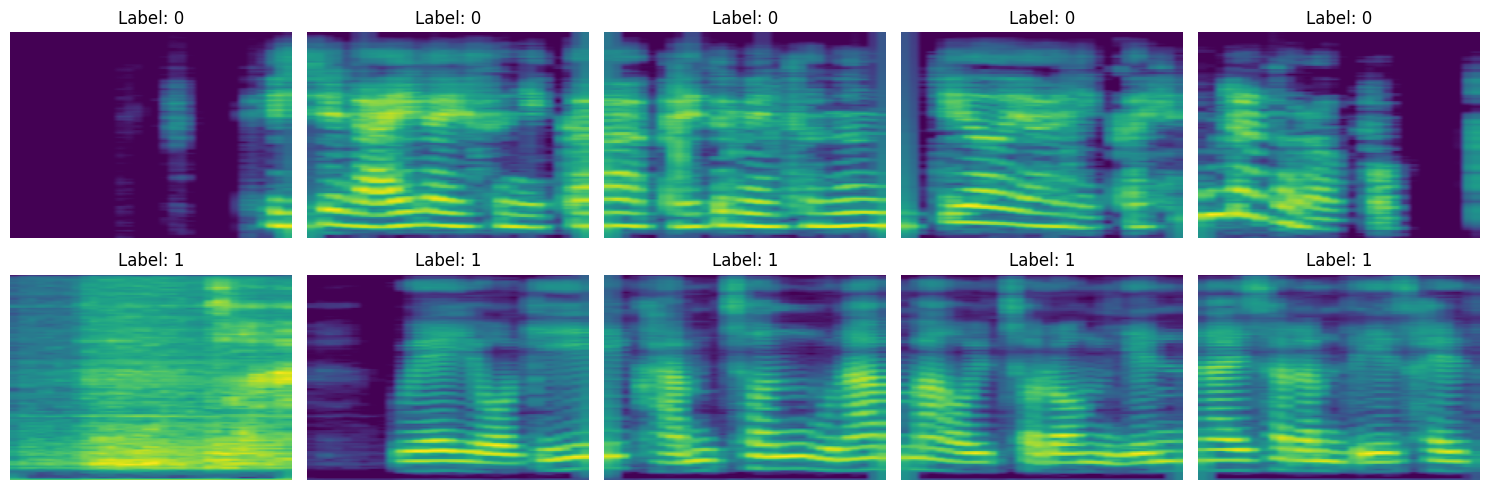

In [75]:
# Visualize 5 samples per label using matplotlib subplots
def plot_samples(X, y, num_samples=5):
    labels = np.unique(y)
    num_labels = len(labels)
    fig, axes = plt.subplots(num_labels, num_samples, figsize=(15, 5))
    for i, label in enumerate(labels):
        idx = np.where(y == label)[0]
        for j in range(num_samples):
            ax = axes[i, j] if num_labels > 1 else axes[j]
            ax.imshow(X[idx[j], :, :, 0], aspect='auto', origin='lower')
            ax.set_title(f'Label: {label}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(X_train, y_train)

## Set Hyperparameter

In [87]:
num_classes = 2
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 128  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extracted from the input images
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [64, 64]  # Size of the dense layers of the final classifier

## Define Vision Transformer

In [88]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

In [89]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.conv = keras.layers.Conv2D(filters=patch_size * patch_size,
                                        kernel_size=patch_size,
                                        strides=patch_size,
                                        padding='valid')

    def call(self, images):
        patches = self.conv(images)
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [tf.shape(images)[0], -1, patch_dims])
        return patches

In [90]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [91]:

# Build ViT Model
def create_vit_classifier():
    inputs = keras.layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.2)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.2)
    # Classify outputs.
    logits = keras.layers.Dense(1, activation='sigmoid')(features)  # Output layer for binary classification
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Model Training

In [92]:
# Compile, Train, Evaluate the Model
def run_experiment(model):
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy")
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_valid, y_valid),
        # validation_split=0.1,
        callbacks=[early_stopping_callback, checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [93]:
vit_classifier = create_vit_classifier()
history, model = run_experiment(vit_classifier)

Epoch 1/100
130/130 [==============================] - 9s 25ms/step - loss: 0.7092 - accuracy: 0.5277 - val_loss: 0.6847 - val_accuracy: 0.5581
Epoch 2/100
130/130 [==============================] - 3s 19ms/step - loss: 0.6889 - accuracy: 0.5478 - val_loss: 0.6798 - val_accuracy: 0.5814
Epoch 3/100
130/130 [==============================] - 2s 19ms/step - loss: 0.6833 - accuracy: 0.5582 - val_loss: 0.6583 - val_accuracy: 0.6632
Epoch 4/100
130/130 [==============================] - 2s 19ms/step - loss: 0.6691 - accuracy: 0.5967 - val_loss: 0.6295 - val_accuracy: 0.6763
Epoch 5/100
130/130 [==============================] - 2s 17ms/step - loss: 0.6589 - accuracy: 0.6039 - val_loss: 0.6310 - val_accuracy: 0.6282
Epoch 6/100
130/130 [==============================] - 2s 19ms/step - loss: 0.6355 - accuracy: 0.6458 - val_loss: 0.5709 - val_accuracy: 0.7086
Epoch 7/100
130/130 [==============================] - 2s 19ms/step - loss: 0.6059 - accuracy: 0.6690 - val_loss: 0.5681 - val_accuracy:

## Export Model to ONNX

In [94]:
# Function to save the model to ONNX
def save_model_to_onnx(model, input_shape, output_path, opset_version=13):
    spec = (tf.TensorSpec((None, *input_shape), tf.float32, name="input"),)
    output_model_path = f"{output_path}.onnx"
    model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=opset_version)
    with open(output_model_path, "wb") as f:
        f.write(model_proto.SerializeToString())
    print(f"Model saved to {output_model_path}")

# Save the trained model to ONNX
save_model_to_onnx(model, input_shape, "vit_classifier", opset_version=13)

Model saved to vit_classifier.onnx


## ONNX Model Test

In [107]:
# !pip install onnxruntime
import os
import numpy as np
import librosa
import onnxruntime as ort
from tqdm import tqdm

def extract_melspectrogram_for_inference(audio_segment, sr=16000, n_mels=128, hop_length=512, max_length=32):
    # Extract Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio_segment, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad or trim the Mel-spectrogram to have the same shape
    if mel_spec_db.shape[1] < max_length:
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, max_length - mel_spec_db.shape[1])), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :max_length]

    return mel_spec_db

# Function to prepare input data for the ONNX model
def prepare_input(audio_segment, max_length=32):
    # Extract features from the audio segment
    features = extract_melspectrogram_for_inference(audio_segment, max_length=max_length)
    # Reshape input data to add channel dimension
    features = features[np.newaxis, ..., np.newaxis].astype(np.float32)
    return features

# Load ONNX model
onnx_model_path = "vit_classifier.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Function to make prediction using ONNX model
def predict_onnx(audio_file, sr=16000):
    # Load audio file
    audio, _ = librosa.load(audio_file, sr=sr)
    # Calculate number of samples per 1 second
    samples_per_second = sr
    num_segments = int(len(audio) / samples_per_second)

    predictions = []

    for i in range(num_segments):
        start_sample = i * samples_per_second
        end_sample = start_sample + samples_per_second
        segment = audio[start_sample:end_sample]

        # Prepare the input
        input_data = prepare_input(segment)

        # Run inference
        input_name = ort_session.get_inputs()[0].name
        result = ort_session.run(None, {input_name: input_data})

        predictions.append(result[0][0][0])  # Append the prediction result for the segment

    return predictions

# Example usage for inference
audio_file = './example' # sample file path
predictions = predict_onnx(audio_file)

if predictions is not None:
    print(f"Predictions: {predictions}")
else:
    print("Failed to process the audio file for prediction")

Predictions: [0.041889727, 0.8379221, 0.05798334, 0.377946, 0.63103735, 0.5879729, 0.7280565, 0.8429651, 0.55591595, 0.0033974946, 0.9997468, 0.18602827, 0.9100044, 0.0062168837, 0.51662153, 0.0012078285, 0.9999052, 0.99088633, 0.999658, 0.98862016, 0.85752356, 0.031567007, 0.001567632, 0.7342267, 0.33906657, 0.93021727, 0.19100204, 0.035324812, 0.87322146, 0.1660564, 0.01822123, 0.9990715, 0.015587121, 0.1605924, 0.122912765, 0.9825094, 0.00012734532, 0.5485764, 0.90760064, 0.23399818, 0.0036222637, 0.9996847, 0.9989834, 0.07232183, 0.97843206, 0.0012176037, 0.5319341, 0.058392435, 0.4120416, 0.9890064, 0.35112962, 0.17798698, 0.95447123, 0.45431477, 0.9851966, 0.9913012, 0.79365396, 0.54918694, 0.8020589, 0.9992969, 0.99999726, 0.9414718, 0.4153297, 0.99968445, 0.6241927, 0.3506325, 0.15646955, 0.7543665, 0.8993238, 0.7940837, 0.9969026, 0.49631232, 0.90366495, 0.9634199, 0.99978924, 0.86949146, 0.87186116, 0.65055317, 0.96605414, 0.8750621, 0.9645771, 0.35931373, 0.9232578, 0.501501

In [108]:
threshold = 0.95
pred_threshold = sum(1 for x in predictions if x >= threshold)

print(f"Number of predictions >= threshold: {pred_threshold}")
print(f"Percentage of FAKE : {pred_threshold/len(predictions)*100}")

Number of predictions >= 0.8: 198
Percentage of FAKE : 33.0
